<h1>Emotion Task

<h3>Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import warnings
import sys
import torch
import torch.nn.functional as F

from torch import nn
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset, Dataset #another way to read dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from datasets.utils.logging import disable_progress_bar

print(sys.version)

warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()
disable_progress_bar()

/home/sonerk/anaconda3/envs/nlp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


<h3>Read Dataset

In [2]:
#already split
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
datasets = {k:pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits[k]) for k in splits}

In [3]:
datasets["train"]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [4]:
len(datasets["train"].label.unique())

6

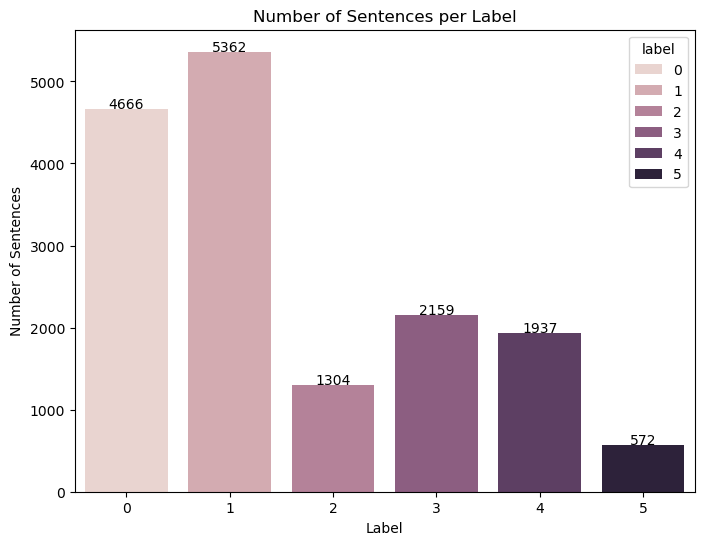

In [5]:
def plot_class_dist(df):
    hist_data = df.label.value_counts().reset_index()


    plt.figure(figsize=(8, 6))
    barplot = sns.barplot(x='label', y='count', hue="label", data=hist_data)

    for index, row in hist_data.iterrows():
        barplot.text(row.label, row['count'], round(row['count'], 2), color='black', ha="center")

    plt.title('Number of Sentences per Label')
    plt.xlabel('Label')
    plt.ylabel('Number of Sentences')
    plt.show()
    
plot_class_dist(datasets["train"])

<h3>Comments:

- Class 5 and class 2 are relatively less compared with the other classes, especially compared the class 0 and class 1. Class 1 and class 2 creates the majority of the dataset, hence, this can lead the bias towards to majority class and poor performance on the minority classes.
- High accuracy won't be enough to calculate the performance of the model because of the imbalances, thus, F1 score can be used.
- Oversampling can be useful to increase minority classes and solve the imbalance problem.
- Class weights can be useful in loss calculations to focus more on minority classes also focal loss can be useful too.

## Pre-processing

In [6]:
from nltk.corpus import wordnet, stopwords
import nltk
import random
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/sonerk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sonerk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [8]:
def random_synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_sentence = words.copy()
    word_indices = [i for i, word in enumerate(words) if wordnet.synsets(word)]
    random.shuffle(word_indices)
    num_replacements = min(n, len(word_indices))
    for idx in word_indices[:num_replacements]:
        synonyms = wordnet.synsets(words[idx])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_sentence[idx] = synonym
    return ' '.join(new_sentence)

def random_insertion(sentence, n=2):
    words = sentence.split()
    for _ in range(n):
        new_word = random.choice(words)
        synonyms = wordnet.synsets(new_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            random_idx = random.randint(0, len(words))
            words.insert(random_idx, synonym)
    return ' '.join(words)

def augment_classes(df, class_list, method):
    rows = df[df.label.isin(class_list)].copy()
    for index, row in rows.iterrows():
        augmented = method(row["text"])
        df.loc[len(df)] = [augmented, row["label"]]

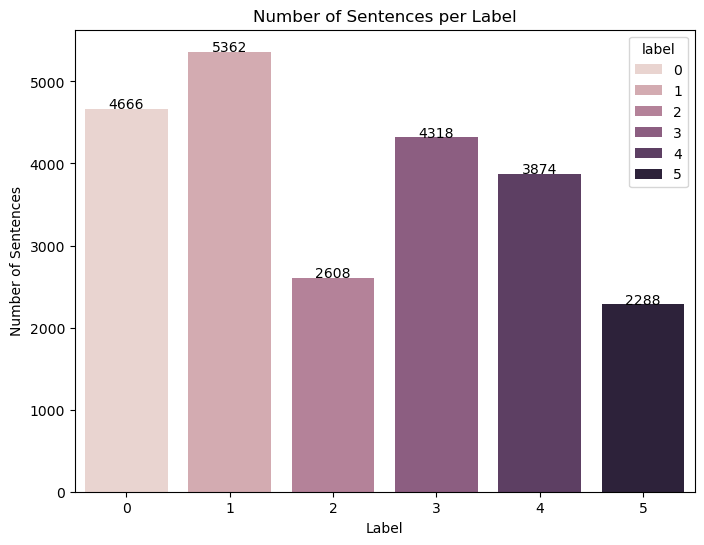

In [9]:
df = datasets["train"].copy()
class_list = [2, 3, 4, 5]

augment_classes(df, class_list, random_synonym_replacement)
augment_classes(df, [5], random_insertion)

plot_class_dist(df)

In [10]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def preprocessing(texts, remove_sws=True, balance=True):
    processed = texts.copy()
    processed = processed.str.lower().replace(r'[^\w\s]', '', regex=True)

    if remove_sws:
        processed = processed.apply(remove_stopwords)
    
    return processed

In [11]:
class_list = [2, 3, 4, 5]
augment_classes(datasets["train"], class_list, random_synonym_replacement)
augment_classes(datasets["train"], [5], random_insertion)

In [12]:
datasets["train"].text = preprocessing(datasets["train"].text)
datasets["validation"].text = preprocessing(datasets["validation"].text)
datasets["test"].text = preprocessing(datasets["test"].text)

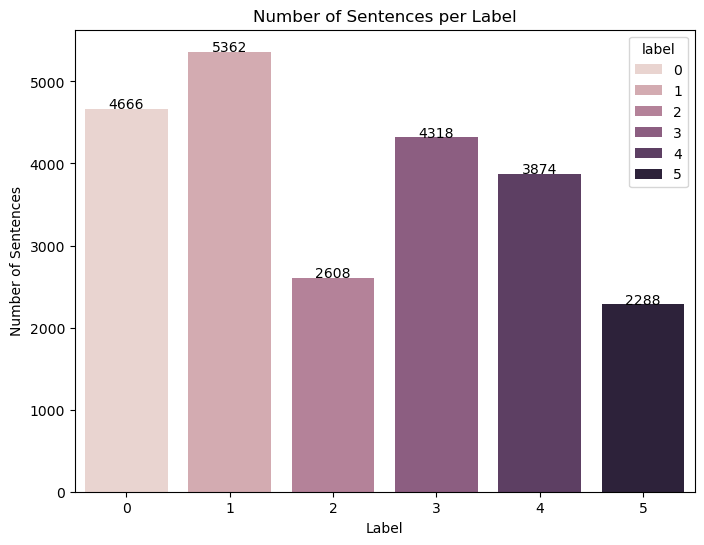

In [13]:
plot_class_dist(datasets["train"])

In [14]:
datasets["train"]

,text,label
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,im grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,3
...,...,...
23111,spend idea washington lot time feeling spot st...,5
23112,iodine believe iodine person readers feel impr...,5
23113,iodine admit admit im iodine feeling pretty ov...,5
23114,feeling much like guy pic little overwhelm sta...,5


In [15]:
labels = datasets["train"].label.to_numpy()
compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

array([0.82568938, 0.71851299, 1.47724949, 0.89223406, 0.9944932 ,
       1.68385781])

In [16]:
def get_class_weights(labels):
    return compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

## Hyperparameter tuning

In [17]:
torch.cuda.is_available()

True

In [18]:
def tokenize(tokenizer, batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=128)

def convert_to_torch_dataset(df, tokenizer):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(lambda batch: tokenize(tokenizer, batch), batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    return dataset

In [19]:
train_small_size = 500
val_small_size = 100
seed = 42

dataset_train_small = datasets["train"].sample(n=train_small_size, random_state = seed)
dataset_val_small = datasets["validation"].sample(n=val_small_size, random_state = seed)

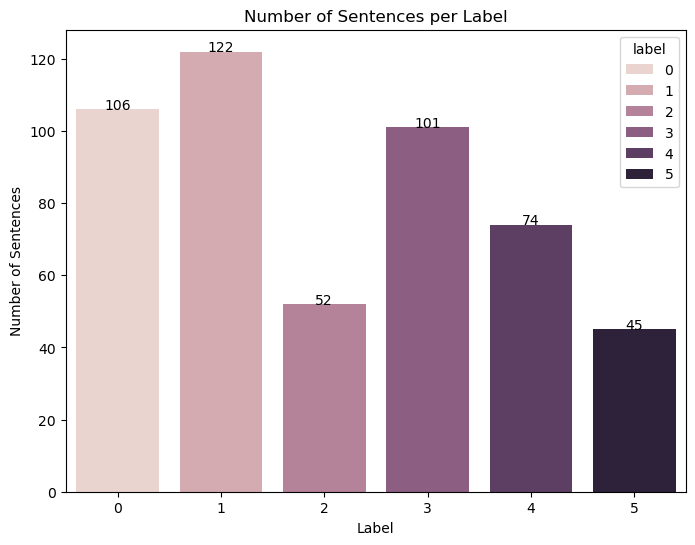

In [20]:
plot_class_dist(dataset_train_small)

In [21]:
class_weights = get_class_weights(datasets["train"].label.to_numpy())
class_weights

array([0.82568938, 0.71851299, 1.47724949, 0.89223406, 0.9944932 ,
       1.68385781])

In [22]:
def focal_loss(p, gamma=2, alpha=1.0):
    return -alpha * (1 - p)**gamma * torch.log(p)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', weight=None):
        """
        alpha: Weighting factor in range (0,1) for balancing classes (set to None for no class balance).
        gamma: Focusing parameter for modulating factor (1-p).
        reduction: Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight

    def forward(self, inputs, targets):
        # Compute cross entropy loss
        CE_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        # Compute the softmax probabilities
        pt = torch.exp(-CE_loss)
        # Compute focal loss
        F_loss = focal_loss(pt, gamma=self.gamma, alpha=self.alpha)

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

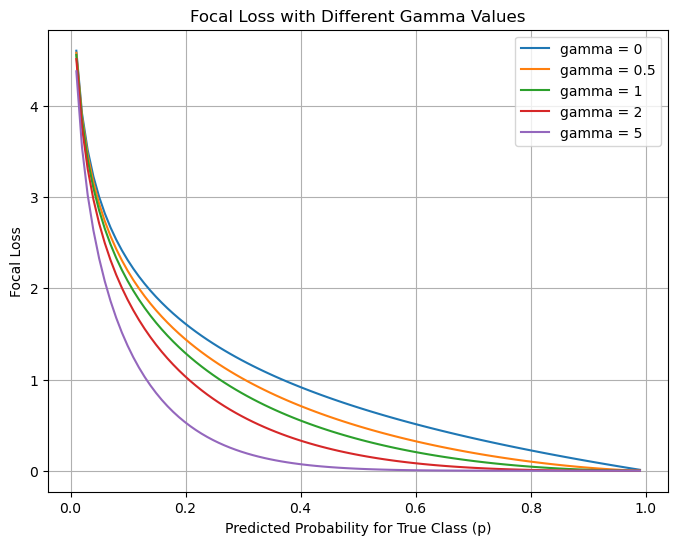

In [23]:
p = np.linspace(0.01, 0.99, 100)

gamma_values = [0, 0.5, 1, 2, 5]
plt.figure(figsize=(8, 6))

for gamma in gamma_values:
    loss = focal_loss(torch.from_numpy(p), gamma=gamma)
    plt.plot(p, loss.numpy(), label=f"gamma = {gamma}")

plt.title("Focal Loss with Different Gamma Values")
plt.xlabel("Predicted Probability for True Class (p)")
plt.ylabel("Focal Loss")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def train_and_eval(train_df, val_df, params, epochs=5):
    epochs = epochs
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    tokenizer = BertTokenizer.from_pretrained(params["model_type"])
    model = BertForSequenceClassification.from_pretrained(params["model_type"], num_labels=6)
    
    train_dataset = convert_to_torch_dataset(train_df, tokenizer)
    val_dataset = convert_to_torch_dataset(val_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])
    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=params["learning_rate"], 
        weight_decay=params.get("weight_decay", 0.0)
    )
    
    loss_fn = None
    weights = torch.from_numpy(class_weights).to(torch.float32).to(device)
    if params.get("weighted", False):
        #loss_fn = torch.nn.CrossEntropyLoss(weight = weights)
        loss_fn = FocalLoss(
            gamma=params.get("gamma", 2.0),
            alpha=params.get("alpha", 1.0),
            weight=weights
        )
    else:
        loss_fn = FocalLoss(
            gamma=params.get("gamma", 2.0),
            alpha=params.get("alpha", 1.0),
        )
    
    model.to(device)
    
    print(f"For parameters {params}:")
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Training phase
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            
            loss = loss_fn(logits, labels.long())
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}')
            
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            label_ids = labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(label_ids)

    score = f1_score(true_labels, predictions, average="micro")
    print(f'Validation f1_score: {score}')
    
    return score
    
    
def get_best_params(train_df, val_df, params_grid, epochs=5):
    best_score = -float("inf")
    best_params = dict()
    for params in params_grid:
        score = train_and_eval(dataset_train_small, dataset_val_small, params, epochs=epochs)
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_score, best_params

In [32]:
params_dict = {
    'model_type': ["bert-base-uncased"],
    #'weighted': [True],
    'learning_rate': [1e-4, 1e-3],
    'batch_size': [32, 64, 128],
    'gamma': [0, 1.0, 2.0, 4.0]
    #'weight_decay': [1e-4, 1e-5, 1e-6],
}

params_grid = ParameterGrid(params_dict)
best_score_bert, best_params_bert = get_best_params(dataset_train_small, dataset_val_small, params_grid)

For parameters {'batch_size': 32, 'gamma': 0, 'learning_rate': 0.0001, 'model_type': 'bert-base-uncased'}:
Epoch 1, Train Loss: 1.74453753978014
Epoch 2, Train Loss: 1.3280097246170044
Epoch 3, Train Loss: 0.7574508115649223
Epoch 4, Train Loss: 0.3362917806953192
Epoch 5, Train Loss: 0.14946074387989938
Validation f1_score: 0.76
For parameters {'batch_size': 32, 'gamma': 0, 'learning_rate': 0.001, 'model_type': 'bert-base-uncased'}:
Epoch 1, Train Loss: 1.9379287213087082
Epoch 2, Train Loss: 1.7743297889828682
Epoch 3, Train Loss: 1.7975810766220093
Epoch 4, Train Loss: 1.7900733947753906
Epoch 5, Train Loss: 1.747616246342659
Validation f1_score: 0.27
For parameters {'batch_size': 32, 'gamma': 1.0, 'learning_rate': 0.0001, 'model_type': 'bert-base-uncased'}:
Epoch 1, Train Loss: 1.4509521648287773
Epoch 2, Train Loss: 1.1251347474753857
Epoch 3, Train Loss: 0.5479110591113567
Epoch 4, Train Loss: 0.22603765642270446
Epoch 5, Train Loss: 0.09776769881136715
Validation f1_score: 0.75


In [33]:
print(best_score_bert)
print(best_params_bert)

0.78
{'batch_size': 64, 'gamma': 0, 'learning_rate': 0.0001, 'model_type': 'bert-base-uncased'}


In [37]:
params_dict = {
    'model_type': ["bert-base-uncased"],
    #'weighted': [True],
    'learning_rate': [2e-5, 1e-4, 5e-4],
    'batch_size': [64],
    'gamma': [0, 0.5, 1],
    #'weight_decay': [1e-4, 1e-5, 1e-6],
}

params_grid = ParameterGrid(params_dict)
best_score_bert, best_params_bert = get_best_params(dataset_train_small, dataset_val_small, params_grid)
print(best_score_bert)
print(best_params_bert)

For parameters {'batch_size': 64, 'gamma': 0, 'learning_rate': 2e-05, 'model_type': 'bert-base-uncased'}:
Epoch 1, Train Loss: 1.7604625225067139
Epoch 2, Train Loss: 1.7037185281515121
Epoch 3, Train Loss: 1.638557568192482
Epoch 4, Train Loss: 1.5756717026233673
Epoch 5, Train Loss: 1.433862566947937
Validation f1_score: 0.4
For parameters {'batch_size': 64, 'gamma': 0, 'learning_rate': 0.0001, 'model_type': 'bert-base-uncased'}:
Epoch 1, Train Loss: 1.7951554656028748
Epoch 2, Train Loss: 1.6501503139734268
Epoch 3, Train Loss: 1.2518534511327744
Epoch 4, Train Loss: 0.6808901727199554
Epoch 5, Train Loss: 0.2904707361012697
Validation f1_score: 0.78
For parameters {'batch_size': 64, 'gamma': 0, 'learning_rate': 0.0005, 'model_type': 'bert-base-uncased'}:
Epoch 1, Train Loss: 1.7832286804914474
Epoch 2, Train Loss: 1.7685249894857407
Epoch 3, Train Loss: 1.767035037279129
Epoch 4, Train Loss: 1.8165578991174698
Epoch 5, Train Loss: 1.7845617681741714
Validation f1_score: 0.31
For pa

In [39]:
params_dict = {
    'model_type': ["bert-base-uncased"],
    'weighted': [False, True],
    'learning_rate': [1e-4],
    'batch_size': [64],
    'gamma': [0.5],
    'weight_decay': [0.0, 1e-4, 1e-5, 1e-6],
}

params_grid = ParameterGrid(params_dict)
best_score_bert, best_params_bert = get_best_params(dataset_train_small, dataset_val_small, params_grid, epochs=10)
print(best_score_bert)
print(best_params_bert)

For parameters {'batch_size': 64, 'gamma': 0.5, 'learning_rate': 0.0001, 'model_type': 'bert-base-uncased', 'weight_decay': 0.0, 'weighted': False}:
Epoch 1, Train Loss: 1.6088097989559174
Epoch 2, Train Loss: 1.412953406572342
Epoch 3, Train Loss: 1.1135205328464508
Epoch 4, Train Loss: 0.7071713805198669
Epoch 5, Train Loss: 0.3618566431105137
Epoch 6, Train Loss: 0.1464164974167943
Epoch 7, Train Loss: 0.0693928268738091
Epoch 8, Train Loss: 0.022480771760456264
Epoch 9, Train Loss: 0.017685371392872185
Epoch 10, Train Loss: 0.008532863517757505
Validation f1_score: 0.79
For parameters {'batch_size': 64, 'gamma': 0.5, 'learning_rate': 0.0001, 'model_type': 'bert-base-uncased', 'weight_decay': 0.0, 'weighted': True}:
Epoch 1, Train Loss: 1.627670332789421
Epoch 2, Train Loss: 1.5631291568279266
Epoch 3, Train Loss: 1.1576629877090454
Epoch 4, Train Loss: 0.7296608239412308
Epoch 5, Train Loss: 0.2847992405295372
Epoch 6, Train Loss: 0.11193404346704483
Epoch 7, Train Loss: 0.05119612

In [25]:
params_dict = {
    'model_type': ["distilbert-base-uncased"],
    'weighted': [True, False],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [32],
    'gamma': [0, 0.5, 1],
    'weight_decay': [0.0, 1e-6],
}

params_grid = ParameterGrid(params_dict)
best_score_distilbert, best_params_distilbert = get_best_params(dataset_train_small, dataset_val_small, params_grid, epochs=8)

For parameters {'batch_size': 32, 'gamma': 0, 'learning_rate': 0.001, 'model_type': 'distilbert-base-uncased', 'weight_decay': 0.0, 'weighted': True}:
Epoch 1, Train Loss: 2.3906323090195656
Epoch 2, Train Loss: 1.886204868555069
Epoch 3, Train Loss: 1.874621942639351
Epoch 4, Train Loss: 1.8353125751018524
Epoch 5, Train Loss: 1.7943029403686523
Epoch 6, Train Loss: 1.8005635812878609
Epoch 7, Train Loss: 1.8399434834718704
Epoch 8, Train Loss: 1.843153327703476
Validation f1_score: 0.27
For parameters {'batch_size': 32, 'gamma': 0, 'learning_rate': 0.001, 'model_type': 'distilbert-base-uncased', 'weight_decay': 0.0, 'weighted': False}:
Epoch 1, Train Loss: 2.951819285750389
Epoch 2, Train Loss: 1.8766893297433853
Epoch 3, Train Loss: 1.8137540966272354
Epoch 4, Train Loss: 1.7791293561458588
Epoch 5, Train Loss: 1.809242032468319
Epoch 6, Train Loss: 1.7886387407779694
Epoch 7, Train Loss: 1.810556784272194
Epoch 8, Train Loss: 1.8536808341741562
Validation f1_score: 0.27
For paramet

KeyboardInterrupt: 

In [ ]:
print(best_score_distilbert)
print(best_params_distilbert)

In [25]:
def train(train_df, val_df, params, epochs=5):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    tokenizer = BertTokenizer.from_pretrained(params["model_type"])
    model = BertForSequenceClassification.from_pretrained(params["model_type"], num_labels=6)
    
    train_dataset = convert_to_torch_dataset(train_df, tokenizer)
    val_dataset = convert_to_torch_dataset(val_df, tokenizer)

    
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])
    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=params["learning_rate"], 
        weight_decay=params.get("weight_decay", 0.0)
    )
    
    loss_fn = None
    weights = torch.from_numpy(class_weights).to(torch.float32).to(device)
    if params.get("weighted", False):
        #loss_fn = torch.nn.CrossEntropyLoss(weight = weights)
        loss_fn = FocalLoss(
            gamma=params.get("gamma", 2.0),
            alpha=params.get("alpha", 1.0),
            weight=weights,
            reduction="mean"
        )
    else:
        loss_fn = FocalLoss(
            gamma=params.get("gamma", 2.0),
            alpha=params.get("alpha", 1.0),
            reduction="mean",
        )
    
    model.to(device)
    max_f1 = -float("inf")
    msg_template = "Train Epoch {epoch} - Focal Loss: {f_loss}"
    for epoch in range(epochs):
        model.train()
        
        total_loss = 0.0
        num_passed = 0.0
        loader = tqdm(train_loader)

        
        # Training phase
        for batch in loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            B = input_ids.size(0)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            
            loss = loss_fn(logits, labels.long())
            
            total_loss += loss.item() * B
            num_passed += B

            loss.backward()
            optimizer.step()
            
            loader.set_description(msg_template.format(epoch=epoch, f_loss= total_loss/num_passed))
            
        model.eval()
        eval_metrics = validate(val_loader, model)
        print(f"Validation Epoch {epoch}:")
        print(eval_metrics)

        if eval_metrics["f1"] > max_f1:
            min_f1 = eval_metrics["f1"]
            torch.save(model, "{}_{}_best.pt".format(params["model_type"], epoch))
            
    
    return model

def validate(val_loader, model):
    predictions, true_labels = [], []
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            label_ids = labels.cpu().numpy()
    
            predictions.extend(preds)
            true_labels.extend(label_ids)
    
    metrics = {
        "f1": f1_score(true_labels, predictions, average="micro"),
        "acc": accuracy_score(true_labels, predictions)
    }
    return metrics

In [26]:
best_params_bert = {'batch_size': 32, 'gamma': 0.5, 'learning_rate': 0.0001, 'model_type': 'bert-base-uncased', 'weight_decay': 0.0, 'weighted': False}
best_params_distilbert = {'batch_size': 32, 'gamma': 0, 'learning_rate': 0.0001, 'model_type': 'distilbert-base-uncased', 'weight_decay': 1e-06, 'weighted': True}

In [27]:
bert_model = train(dataset_train_small, dataset_val_small, best_params_bert, epochs=15)

Train Epoch 0 - Focal Loss: 1.6024139394760133: 100%|█| 16/16 [00:09<00:00,  1.6


Validation Epoch 0:
{'f1': 0.47, 'acc': 0.47}


Train Epoch 1 - Focal Loss: 1.2276220412254333: 100%|█| 16/16 [00:09<00:00,  1.7


Validation Epoch 1:
{'f1': 0.61, 'acc': 0.61}


Train Epoch 2 - Focal Loss: 0.5627620348930359: 100%|█| 16/16 [00:09<00:00,  1.7


Validation Epoch 2:
{'f1': 0.76, 'acc': 0.76}


Train Epoch 3 - Focal Loss: 0.27308425706624984: 100%|█| 16/16 [00:09<00:00,  1.


Validation Epoch 3:
{'f1': 0.73, 'acc': 0.73}


Train Epoch 4 - Focal Loss: 0.13731605672836303: 100%|█| 16/16 [00:10<00:00,  1.


Validation Epoch 4:
{'f1': 0.79, 'acc': 0.79}


Train Epoch 5 - Focal Loss: 0.07737074538320303: 100%|█| 16/16 [00:12<00:00,  1.


Validation Epoch 5:
{'f1': 0.78, 'acc': 0.78}


Train Epoch 6 - Focal Loss: 0.04147933666408062: 100%|█| 16/16 [00:13<00:00,  1.


Validation Epoch 6:
{'f1': 0.75, 'acc': 0.75}


Train Epoch 7 - Focal Loss: 0.022111626505851745: 100%|█| 16/16 [00:13<00:00,  1


Validation Epoch 7:
{'f1': 0.76, 'acc': 0.76}


Train Epoch 8 - Focal Loss: 0.009981792028993368: 100%|█| 16/16 [00:12<00:00,  1


Validation Epoch 8:
{'f1': 0.76, 'acc': 0.76}


Train Epoch 9 - Focal Loss: 0.0061290997946634885: 100%|█| 16/16 [00:13<00:00,  


Validation Epoch 9:
{'f1': 0.74, 'acc': 0.74}


Train Epoch 10 - Focal Loss: 0.00401424540951848: 100%|█| 16/16 [00:12<00:00,  1


Validation Epoch 10:
{'f1': 0.74, 'acc': 0.74}


Train Epoch 11 - Focal Loss: 0.002699776004999876: 100%|█| 16/16 [00:13<00:00,  


Validation Epoch 11:
{'f1': 0.73, 'acc': 0.73}


Train Epoch 12 - Focal Loss: 0.02734510713815689: 100%|█| 16/16 [00:13<00:00,  1


Validation Epoch 12:
{'f1': 0.68, 'acc': 0.68}


Train Epoch 13 - Focal Loss: 0.09993836548179388: 100%|█| 16/16 [00:11<00:00,  1


Validation Epoch 13:
{'f1': 0.75, 'acc': 0.75}


Train Epoch 14 - Focal Loss: 0.07390808434039355: 100%|█| 16/16 [00:11<00:00,  1


Validation Epoch 14:
{'f1': 0.78, 'acc': 0.78}


In [28]:
distil_bert_model = train(dataset_train_small, dataset_val_small, best_params_distilbert, epochs=15)

Train Epoch 0 - Focal Loss: 1.959618660926819: 100%|█| 16/16 [00:11<00:00,  1.45


Validation Epoch 0:
{'f1': 0.1, 'acc': 0.1}


Train Epoch 1 - Focal Loss: 1.7949633722305298: 100%|█| 16/16 [00:11<00:00,  1.3


Validation Epoch 1:
{'f1': 0.15, 'acc': 0.15}


Train Epoch 2 - Focal Loss: 1.802233283996582: 100%|█| 16/16 [00:12<00:00,  1.32


Validation Epoch 2:
{'f1': 0.27, 'acc': 0.27}


Train Epoch 3 - Focal Loss: 1.8087242212295531: 100%|█| 16/16 [00:13<00:00,  1.2


Validation Epoch 3:
{'f1': 0.07, 'acc': 0.07}


Train Epoch 4 - Focal Loss: 1.82548477935791: 100%|█| 16/16 [00:12<00:00,  1.32i


Validation Epoch 4:
{'f1': 0.15, 'acc': 0.15}


Train Epoch 5 - Focal Loss: 1.7861412734985351: 100%|█| 16/16 [00:12<00:00,  1.3


Validation Epoch 5:
{'f1': 0.27, 'acc': 0.27}


Train Epoch 6 - Focal Loss: 1.7797052516937255: 100%|█| 16/16 [00:12<00:00,  1.3


Validation Epoch 6:
{'f1': 0.31, 'acc': 0.31}


Train Epoch 7 - Focal Loss: 1.7932622470855712: 100%|█| 16/16 [00:12<00:00,  1.3


Validation Epoch 7:
{'f1': 0.27, 'acc': 0.27}


Train Epoch 8 - Focal Loss: 1.7890682907104491: 100%|█| 16/16 [00:12<00:00,  1.2


Validation Epoch 8:
{'f1': 0.15, 'acc': 0.15}


Train Epoch 9 - Focal Loss: 1.7841843576431275: 100%|█| 16/16 [00:12<00:00,  1.2


Validation Epoch 9:
{'f1': 0.31, 'acc': 0.31}


Train Epoch 10 - Focal Loss: 1.7835931024551392: 100%|█| 16/16 [00:13<00:00,  1.


Validation Epoch 10:
{'f1': 0.27, 'acc': 0.27}


Train Epoch 11 - Focal Loss: 1.7930518884658813: 100%|█| 16/16 [00:12<00:00,  1.


Validation Epoch 11:
{'f1': 0.27, 'acc': 0.27}


Train Epoch 12 - Focal Loss: 1.7940349349975586: 100%|█| 16/16 [00:12<00:00,  1.


Validation Epoch 12:
{'f1': 0.27, 'acc': 0.27}


Train Epoch 13 - Focal Loss: 1.7819949884414672: 100%|█| 16/16 [00:12<00:00,  1.


Validation Epoch 13:
{'f1': 0.15, 'acc': 0.15}


Train Epoch 14 - Focal Loss: 1.780105131149292: 100%|█| 16/16 [00:13<00:00,  1.2


Validation Epoch 14:
{'f1': 0.15, 'acc': 0.15}


<h3>Comments on Hyperparameter Tuning and Model Training</h3>

- Both BERT and DistilBERT are used with get best parameters to detect the best hyperparameters. Using these hyperparameters both of the models are trained with 500 sample size and epoch size of 15.
- Analyzing the results it can be noticed that BERT model is overfitting and DistilBERTH is underfitting. The reason behind these is BERT has more capacity than distilBERT hence, it can learn more complex relations. But this leads to overfit due to the small sample size and also because of the capacity difference DistilBERT underfits. 

- For this problem more time and resources were needed to try more things, and explore the results in more visualised and better ways. Bigger sample size and epochs could have been useful at the final training.

- Improvement could be have done by visualizing the loss values for training and validation with tensorboard.

<h3>Load Model

In [47]:
device = "cuda" # the device to load the model onto
model_name = "bert-base-uncased_14_best.pt"

bert_model = torch.load("bert-base-uncased_14_best.pt")
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [48]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [49]:
dataset_test_small = datasets["test"].sample(n=100, random_state = 42)

In [50]:
def test(model, tokenizer, test_df, device):
    test_dataset = convert_to_torch_dataset(test_df, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    predictions, true_labels, input_ids_all = [], [], []
        
    with torch.no_grad():
        for batch in test_loader:
            input_ids_all.extend(batch['input_ids'].cpu().numpy())
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            label_ids = labels.cpu().numpy()
    
            predictions.extend(preds)
            true_labels.extend(label_ids)
    
    metrics = {
        "f1": f1_score(true_labels, predictions, average="micro"),
        "acc": accuracy_score(true_labels, predictions)
    }
    return predictions, true_labels, metrics, input_ids_all

In [51]:
predictions, true_labels, metrics, input_ids = test(bert_model, tokenizer, dataset_test_small, device)

In [35]:
metrics

{'f1': 0.85, 'acc': 0.85}

In [57]:
def get_embeddings(input_ids, model):
    with torch.no_grad():
        embeddings = model.bert.embeddings(torch.LongTensor(input_ids).to("cuda"))
    return embeddings

In [60]:
import shap

embeddings = get_embeddings(input_ids, bert_model)
background = embeddings[:1]

# Create a SHAP DeepExplainer
explainer = shap.DeepExplainer(bert_model, background)

# Explain the predictions of the test set
shap_values = explainer.shap_values(embeddings)

# Visualize the SHAP values for the first prediction
shap.summary_plot(shap_values[0], embeddings[0].cpu().numpy())

ValueError: too many values to unpack (expected 2)